In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats 
import math
import tensorflow as tf
import GPy

df = pd.read_pickle('train.pkl')
sns.set(style="darkgrid")
np.random.seed(1)

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


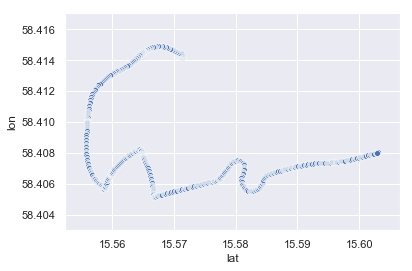

In [2]:
traj_df = df[df.traj == 1]
sns.scatterplot(x="lat", y="lon", data=traj_df)

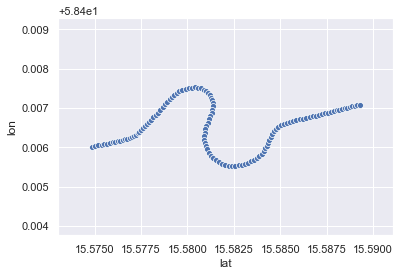

In [3]:
seg = traj_df[traj_df.seg == 9]
sns.scatterplot(x="lat", y="lon", data=seg)

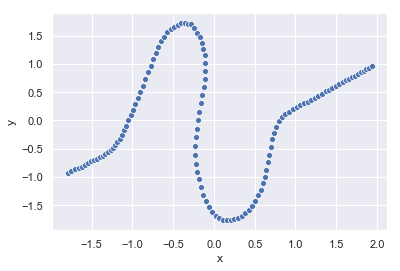

In [4]:
X_unnorm = np.vstack((seg['lat'], seg['lon'])).T 
scaler = StandardScaler().fit(X_unnorm)
X = scaler.transform(X_unnorm)

norm_traj= pd.DataFrame(X, columns = list('xy'))
sns.scatterplot(x='x', y='y', data=norm_traj)

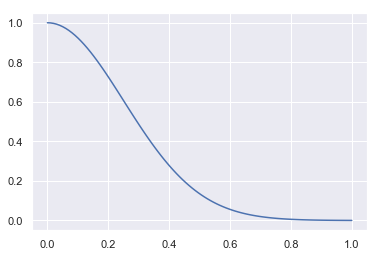

In [5]:
def rbf(X, x, var, l):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(l, 2)))

xmin = 0
xmax = 1
xx = np.linspace(xmin, xmax, 100)[:,None]
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.25)[:,0])

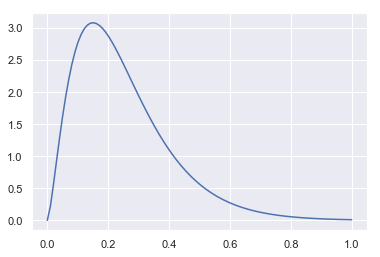

In [6]:
xmin = 0
xmax = 1
l_alpha = 2.5
l_theta = 0.1
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=l_alpha, scale=l_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

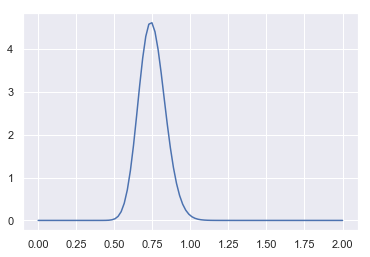

In [7]:
xmin = 0
xmax = 2
sigmaf_alpha = 75
sigmaf_theta = 0.01
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigmaf_alpha, scale=sigmaf_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

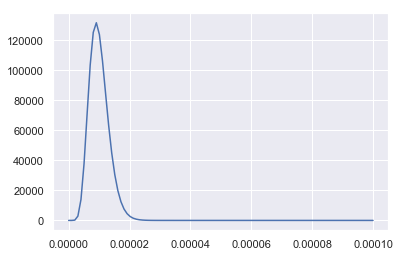

In [8]:
xmin = 0
xmax = 0.0001
sigma_alpha = 10
sigma_theta = 0.000001
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigma_alpha, scale=sigma_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

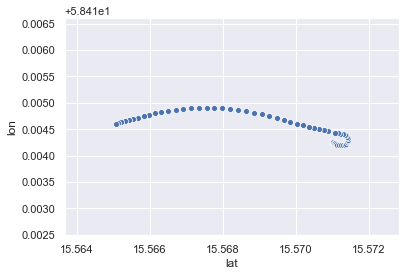

In [9]:
np.random.seed(1)
n_trajs = 100 # Use only a small amount of trajectories to save time
seg_n = 1
traj_n = 5

data = pd.read_pickle('train.pkl')
data = data[(data.traj < n_trajs) & (data.seg == seg_n)]
n_trajs = int(data.traj.max())
n_train = round(n_trajs*0.8)
train_ixs = np.random.randint(0, n_trajs-1, n_train)
train = data[data.traj.transform(lambda x: x in train_ixs)]
valid = data[data.traj.transform(lambda x: x not in train_ixs)]
train_traj = train[train.traj < traj_n]
valid_trajs = valid
sns.scatterplot(x="lat", y="lon", data=train_traj)

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.57166533,+ve,"Ga(0.9, 3)"
[1],0.71374695,+ve,"Ga(0.9, 3)"


 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


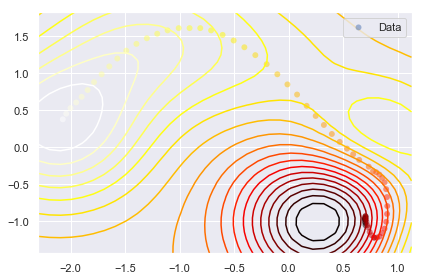

In [11]:
#from models.synch import gamma_prior

def __normalise(data):
    scaler = StandardScaler().fit(data)
    return scaler.transform(data)

def build(X, Y, l_prior, sigmaf_prior, sigma_prior):
    X_norm = __normalise(X)
    Y_norm = __normalise(Y)
    d = X.shape[1]

    rbf = GPy.kern.RBF(input_dim = 2, ARD = True)
    model = GPy.models.GPRegression(X_norm, Y_norm, rbf)
    
    model.kern.lengthscale.set_prior(l_prior)
    model.kern.variance.set_prior(sigmaf_prior)
    model.likelihood.variance.set_prior(sigma_prior)

    return model

train_x = np.vstack((train_traj['lat'], train_traj['lon'])).T
train_y = 1 - np.array(train_traj['t']).reshape(train_traj.shape[0],1) / train_traj['t'].max() # Temporal progress
valid_x = np.vstack((valid_trajs['lat'], valid_trajs['lon'])).T
valid_y = 1 - np.array(valid_trajs['t']).reshape(valid_trajs.shape[0],1) / valid_trajs['t'].max() # Temporal progress
np.random.seed(1)

model = build(
    train_x, 
    train_y,
    GPy.priors.Gamma.from_EV(0.3, 0.1),
    GPy.priors.Gamma.from_EV(0.6, 0.3),
    GPy.priors.Gamma.from_EV(0.001, 0.1)
)

n_runs = 10


model.optimize(messages = True, max_f_eval = 1000) # this should probably be with restarts

fig = model.plot()

model.kern.lengthscale

In [12]:
model.kern.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.57166533,+ve,"Ga(0.9, 3)"
[1],0.71374695,+ve,"Ga(0.9, 3)"


[Text(0,0.5,'Prediction'), Text(0.5,0,'Ground truth')]

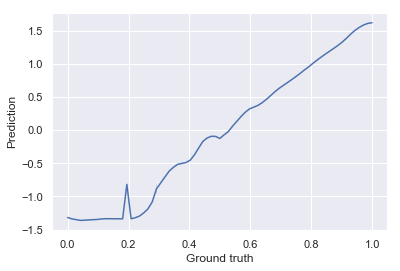

In [13]:
mean, var = model.predict(__normalise(train_x))

df = pd.DataFrame(np.hstack([train_x, train_y, mean]), columns=list('xypm'))
ax = sns.lineplot(x='p', y='m', data=df)
ax.set(xlabel='Ground truth', ylabel='Prediction')

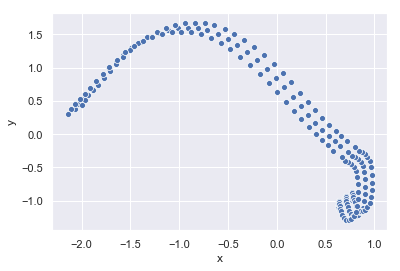

In [14]:
scaler = StandardScaler().fit(train_x)
X = scaler.transform(train_x)
u, s, vh = np.linalg.svd(X)
v1 = 0.1*vh[1,:]
norm_traj= pd.DataFrame(np.vstack((X, X+v1, X-v1)), columns = list('xy'))
sns.scatterplot(x='x', y='y', data=norm_traj)

reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.54031526,+ve,"Ga(0.9, 3)"
[1],0.44641457,+ve,"Ga(0.9, 3)"


 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


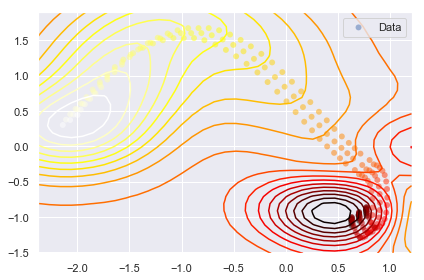

In [15]:
model = build(
    np.vstack((X, X+v1, X-v1)), 
    np.vstack((train_y, train_y, train_y)),
    GPy.priors.Gamma.from_EV(0.3, 0.1),
    GPy.priors.Gamma.from_EV(0.6, 0.3),
    GPy.priors.Gamma.from_EV(0.001, 0.1)
)

model.optimize(messages = True, max_f_eval = 1000)

fig = model.plot()

model.kern.lengthscale

[Text(0,0.5,'Prediction'), Text(0.5,0,'Ground truth')]

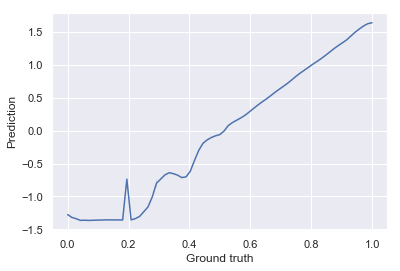

In [16]:
mean, var = model.predict(__normalise(train_x))

df = pd.DataFrame(np.hstack([train_x, train_y, mean]), columns=list('xypm'))
ax = sns.lineplot(x='p', y='m', data=df)
ax.set(xlabel='Ground truth', ylabel='Prediction')